In [50]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[1] "glove-6b"                            "go-emotions-google-emotions-dataset"

# EmotionTrack Tutor Text classification project
## Problem definition
The objective of this project is to develop a Semi-Structured Distributional Regression (SSMR) model capable of detecting and classifying a
user's emotion into Paul Ekman’s Six Universal Emotions: Anger, Disgust, Enjoyment, Fear, Sadness, and Surprise when a user comments somenting on the app. This model will be integrated
into the EmotionTrack Tutor app, an educational platform designed for Android devices that utilizes virtual reality (VR) environments. The app
aims to engage users emotionally during their learning process through interactive simulations, while reducing the effects of the uncanny valley
—a phenomenon where human-like avatars evoke discomfort due to subtle imperfections in realism.

## Data
The data used in this project is sourced from kaggle:https://www.kaggle.com/datasets/shivamb/go-emotions-google-emotions-dataset

### data description
**About the Dataset**  
The Google AI GoEmotions dataset contains Reddit user comments annotated with emotional labels. It is designed to help train neural networks for deep text analysis based on emotional tone. Unlike many existing emotion classification datasets, which often focus on specific domains (like news headlines or movie subtitles), are relatively small, and only include six basic emotions (anger, surprise, disgust, joy, fear, and sadness), GoEmotions offers a broader emotional range. This makes it valuable for applications like building more empathetic chatbots, detecting harmful online behavior, and enhancing customer service.

The dataset's emotion categories were developed by Google in collaboration with psychologists. It includes 12 positive, 11 negative, 4 ambiguous, and 1 neutral emotion, making it ideal for tasks that require fine-grained emotional distinctions.


## Evaluation
The mode of evaluation on how the models performed was using loss function and accuracy

## Features
Here are the columns in the dataset:
id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral

In [51]:
# List of required libraries
required_libraries <- c(
"tidymodels","readr","keras","tensorflow","reticulate")

install.packages(required_libraries)

#Import the packages
library(tidymodels)
library(readr)
library(keras)
library(tensorflow)
library(reticulate)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [52]:
#load data
path <- '/kaggle/input/go-emotions-google-emotions-dataset/go_emotions_dataset.csv'
data <-read.csv(path)
glimpse(data)

Rows: 211,225
Columns: 31
$ id                   <chr> "eew5j0j", "eemcysk", "ed2mah1", "eeibobj", "eda6…
$ text                 <chr> "That game hurt.", " >sexuality shouldn’t be a gr…
$ example_very_unclear <chr> "False", "True", "False", "False", "False", "Fals…
$ admiration           <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0…
$ amusement            <int> 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0…
$ anger                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ annoyance            <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ approval             <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ caring               <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ confusion            <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ curiosity            <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ desire               <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ disappointme

## Data Preparation

In [53]:
# Extract relevant emotions(Paul Ekman’s Six Universal Emotions)
selected_emotions <- data %>%
  select(text, anger, surprise, disgust, joy, fear, sadness)

In [54]:
# Prepare the labels by merging columns
selected_emotions$label <- apply(selected_emotions[ , 2:7], 1, function(x) as.integer(any(x == 1)))

In [55]:
# Tokenization of the text
max_words <- 10000
tokenizer <- text_tokenizer(num_words = max_words) %>%
  fit_text_tokenizer(selected_emotions$text)
sequences <- texts_to_sequences(tokenizer, selected_emotions$text)

In [56]:
# Padding the sequences
maxlen <- 100
data_padded <- pad_sequences(sequences, maxlen = maxlen)

In [57]:
# Split the dataset into training and test sets
set.seed(12345)
train_indices <- createDataPartition(selected_emotions$label, p = 0.8, list = FALSE)
x_train <- data_padded[train_indices, ]
head(x_train)

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,8,134,510
0,0,0,0,0,0,0,0,0,0,⋯,54,2915,23,833,9,2274,1,1858,11,7495
0,0,0,0,0,0,0,0,0,0,⋯,5,39,93,32,5,52,312,101,197,4427
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,110,2,47,336
0,0,0,0,0,0,0,0,0,0,⋯,10,15,2423,934,64,30,15,92,1,8781
0,0,0,0,0,0,0,0,0,0,⋯,2782,114,3226,6,6537,77,217,14,1,206


In [58]:
x_test <- data_padded[-train_indices, ]
head(x_test)

0,0,0,0,0,0,0,0,0,0,⋯,186,601,1,529,386,163,8,2075,2370,3044
0,0,0,0,0,0,0,0,0,0,⋯,0,0,18,35,10,272,9,23,6000,1887
0,0,0,0,0,0,0,0,0,0,⋯,16,876,7497,3902,35,85,20,63,93,67
0,0,0,0,0,0,0,0,0,0,⋯,91,873,2441,12,429,359,480,17,8092,1032
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,5846,16,173,117,14,1,1859
0,0,0,0,0,0,0,0,0,0,⋯,172,178,1,1116,18,93,67,218,7,1542


In [59]:
y_train <- selected_emotions$label[train_indices]
head(y_train)

[1] 1 0 0 0 0 0

In [60]:
y_test <- selected_emotions$label[-train_indices]
head(y_test)

[1] 0 0 0 0 0 0

## Building models

## Simple Word Embedding

In [61]:
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [62]:
library(caret)

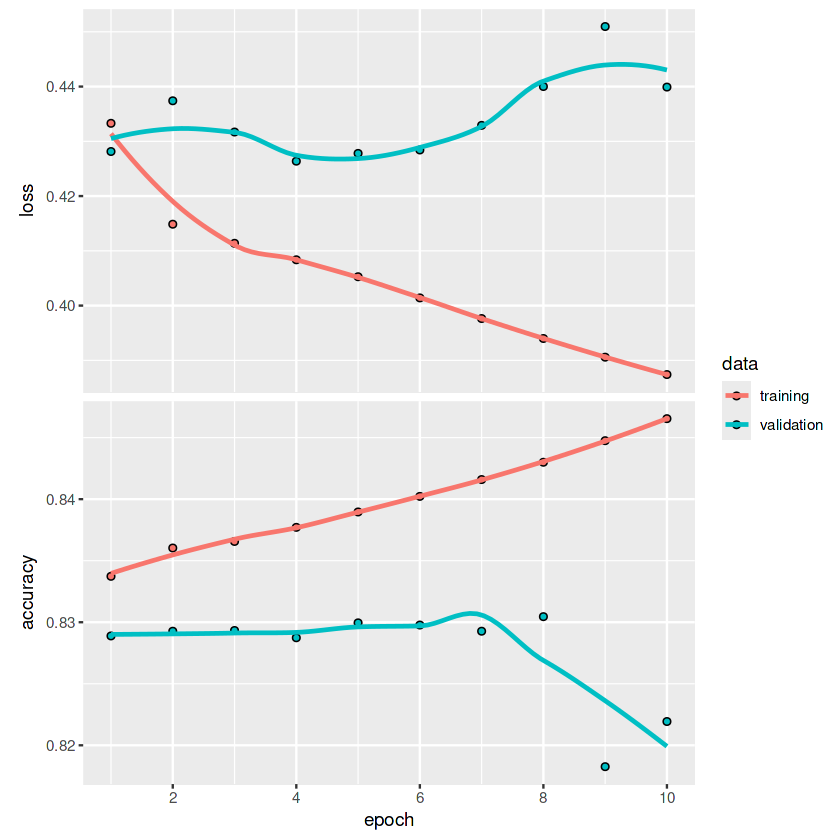

In [63]:
model_one <- keras_model_sequential() %>%
  layer_embedding(input_dim = max_words, output_dim = 8, input_length = maxlen) %>%
  layer_flatten() %>%
  layer_dense(units = 1, activation = "sigmoid")

model_one %>% compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = c("accuracy"))

history_one <- model_one %>% fit(x_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.2)
plot(history_one)

## Model 2: Pretrained word embeddings (using GloVe)

In [64]:
prepare_glove_embeddings <- function(glove_dir, tokenizer, max_words, embedding_dim) {
  glove_file <- file.path(glove_dir, paste0("glove.6B.", embedding_dim, "d.txt"))
  embeddings_index <- new.env()
  con <- file(glove_file, open = "r")
  while(TRUE) {
    line <- readLines(con, n = 1, warn = FALSE)
    if (length(line) == 0) break
    values <- unlist(strsplit(line, " "))
    word <- values[1]
    coefs <- as.numeric(values[-1])
    embeddings_index[[word]] <- coefs
  }
  close(con)
  word_index <- tokenizer$word_index
  embedding_matrix <- matrix(0, nrow = max_words, ncol = embedding_dim)
  
  for (word in names(word_index)) {
    index <- word_index[[word]]
    if (index < max_words) {
      embedding_vector <- embeddings_index[[word]]
      if (!is.null(embedding_vector)) {
        embedding_matrix[index + 1, ] <- embedding_vector
      }
    }
  }
  return(embedding_matrix)
}

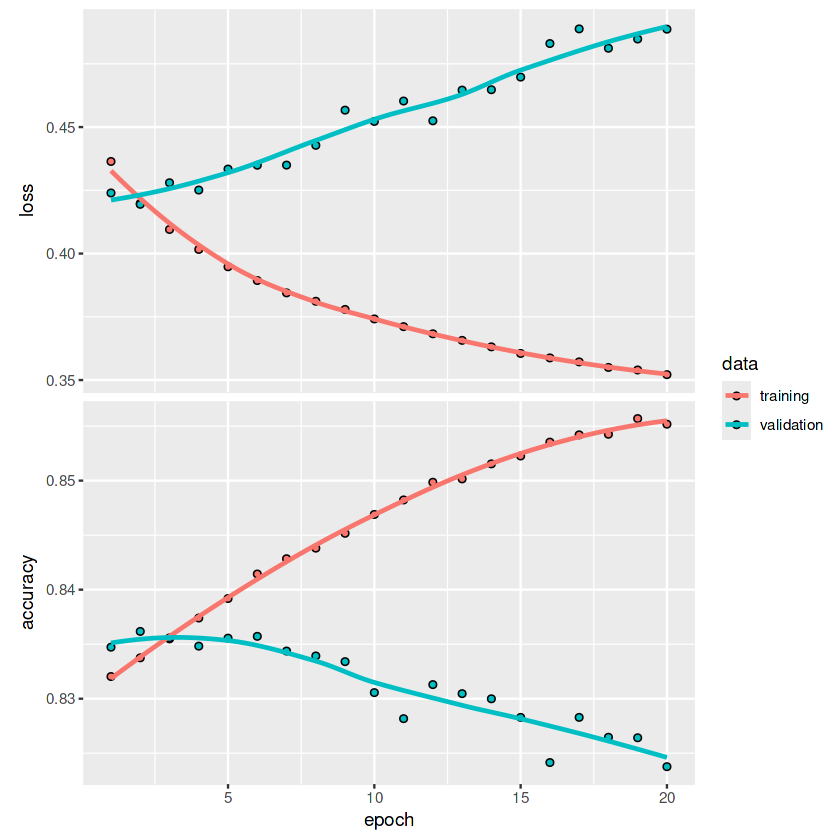

In [65]:
glove_dir <- '/kaggle/input/glove-6b'
embedding_dim <- 100
embedding_matrix <- prepare_glove_embeddings(glove_dir, tokenizer, max_words, embedding_dim)

model_two <- keras_model_sequential() %>%
  layer_embedding(input_dim = max_words, output_dim = embedding_dim, input_length = maxlen) %>%
  layer_flatten() %>%
  layer_dense(units = 32, activation = "relu") %>%
  layer_dense(units = 1, activation = "sigmoid")

get_layer(model_two, index = 1) %>% set_weights(list(embedding_matrix)) %>% freeze_weights()

model_two %>% compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = c("accuracy"))

history_two <- model_two %>% fit(x_train, y_train, epochs = 20, batch_size = 32, validation_data = list(x_test, y_test))
plot(history_two)

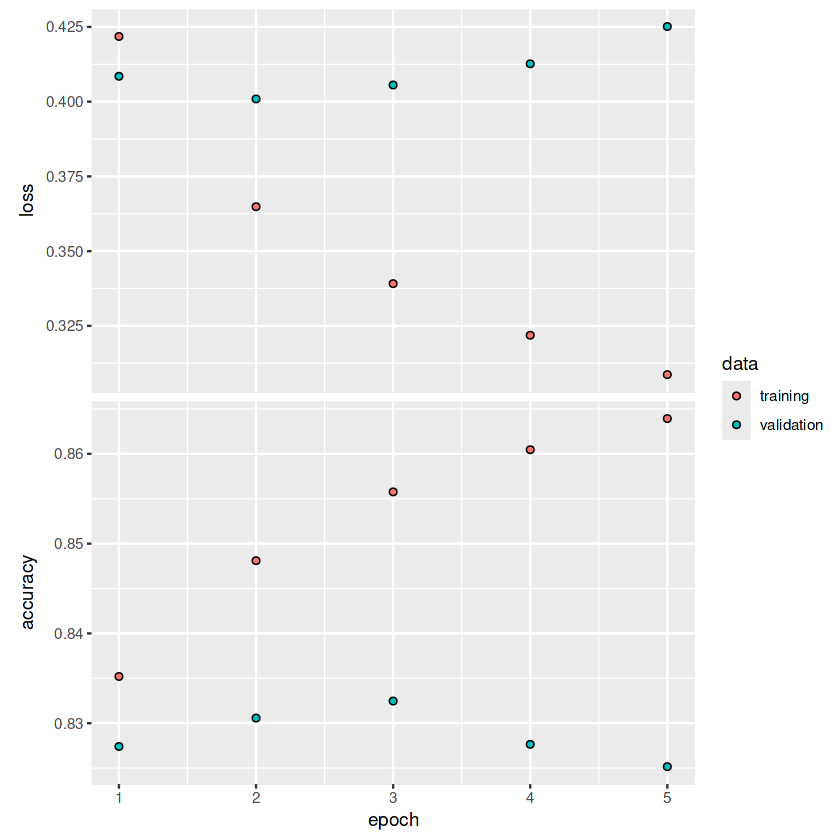

In [66]:
model_three <- keras_model_sequential() %>%
  layer_embedding(input_dim = max_words, output_dim = 16, input_length = maxlen) %>%
  layer_simple_rnn(units = 16) %>%  
  layer_dense(units = 1, activation = "sigmoid")

model_three %>% compile(optimizer = "adam", loss = "binary_crossentropy", metrics = c("accuracy")) 

history_three <- model_three %>% fit(x_train, y_train, epochs = 5, batch_size = 64, validation_split = 0.2) 
plot(history_three)

In [67]:
# Evaluating models
eval_one <- model_one %>% evaluate(x_test, y_test)
eval_two <- model_two %>% evaluate(x_test, y_test)
eval_three <- model_three %>% evaluate(x_test, y_test)

In [68]:
print(eval_one)

     loss  accuracy 
0.4321080 0.8292106 


In [69]:
print(eval_two)

     loss  accuracy 
0.4886908 0.8237661 


In [70]:
eval_three

loss  accuracy 
0.4170946 0.8295420

## 1D Convolutional Neural Network

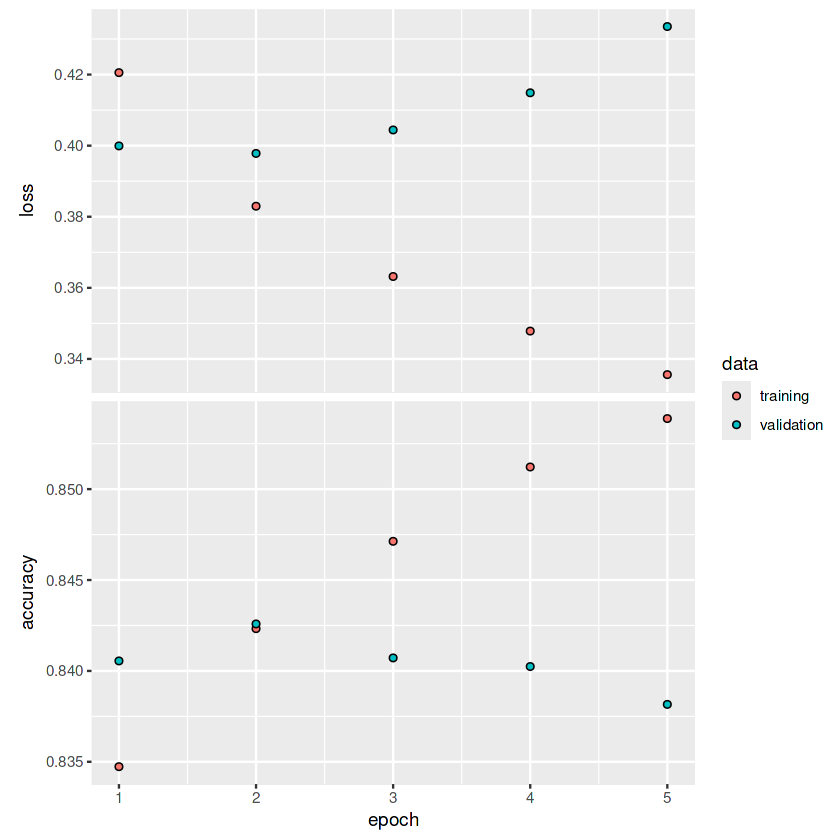

In [71]:
model_four <- keras_model_sequential() %>%
  layer_embedding(input_dim = max_words, output_dim = 16, input_length = maxlen) %>% 
  layer_conv_1d(filters = 16, kernel_size = 3, activation = "relu") %>% 
  layer_max_pooling_1d(pool_size = 3) %>%
  layer_conv_1d(filters = 16, kernel_size = 3, activation = "relu") %>%
  layer_max_pooling_1d(pool_size = 3) %>%
  layer_flatten() %>%
  layer_dense(units = 16, activation = "relu") %>%  
  layer_dense(units = 1, activation = "sigmoid")

model_four %>% compile(optimizer = "adam", loss = "binary_crossentropy", metrics = c("accuracy"))  

history_four <- model_four %>% fit(x_train, y_train, epochs = 5, batch_size = 64, validation_data = list(x_test, y_test)) 
plot(history_four)

## RNN (Recurrent Neural Network)

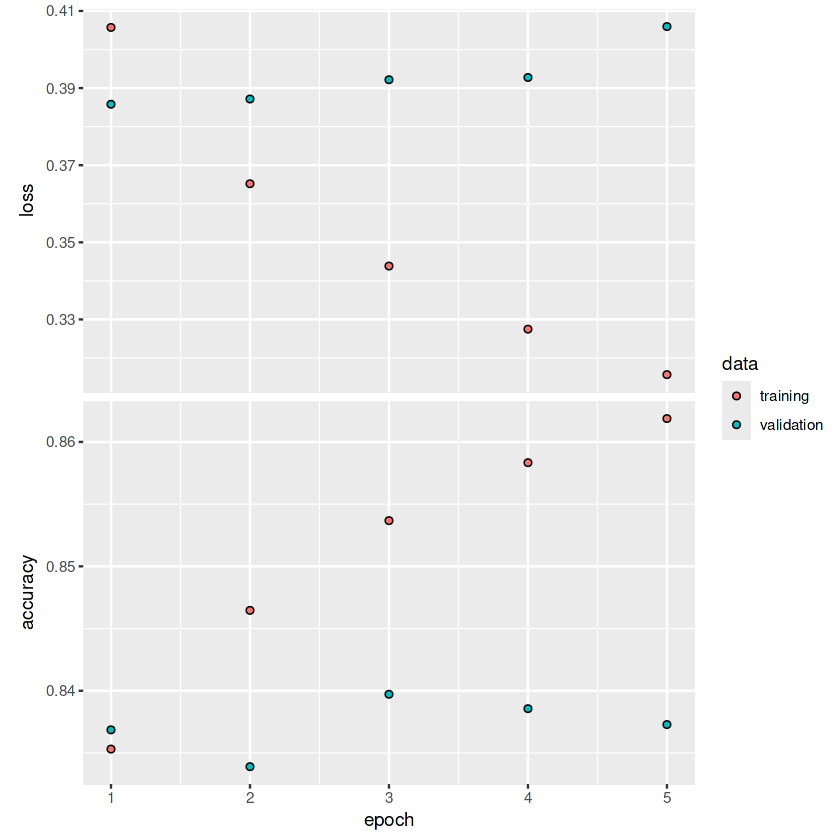

In [72]:
model_five <- keras_model_sequential() %>%
  layer_embedding(input_dim = max_words, output_dim = 16, input_length = maxlen) %>%
  layer_simple_rnn(units = 16) %>%  
  layer_dense(units = 16, activation = "relu") %>%  
  layer_dense(units = 1, activation = "sigmoid")

model_five %>% compile(optimizer = "adam", loss = "binary_crossentropy", metrics = c("accuracy"))  

history_five <- model_five %>% fit(x_train, y_train, epochs = 5, batch_size = 64, validation_data = list(x_test, y_test))  
plot(history_five)


##  LSTM (Long Short-Term Memory) Network

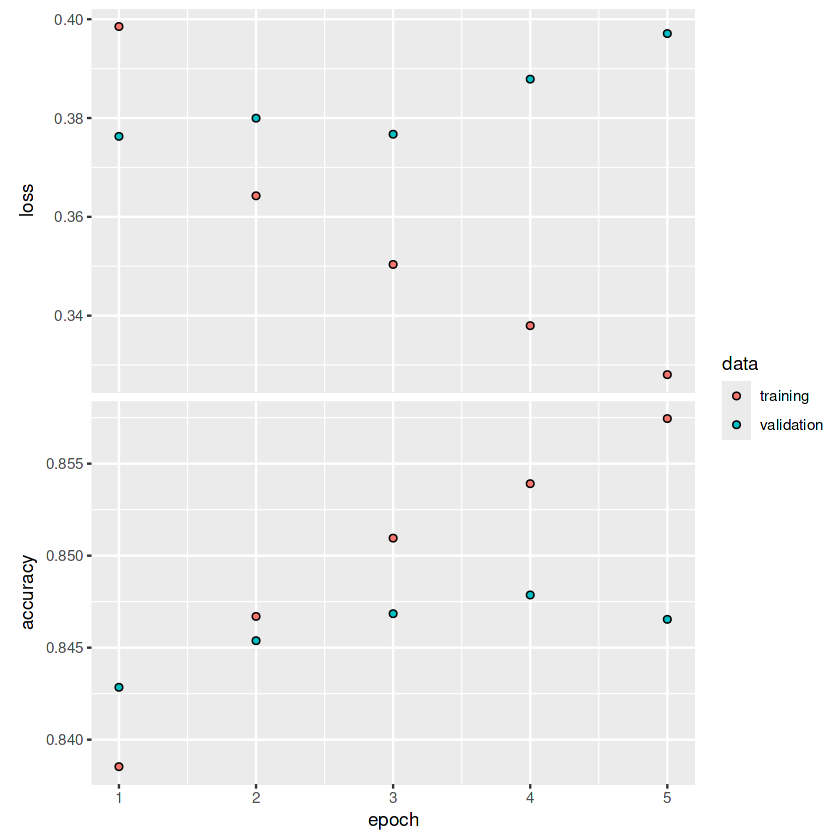

In [73]:
model_six <- keras_model_sequential() %>%
  layer_embedding(input_dim = max_words, output_dim = 16, input_length = maxlen) %>%  
  layer_lstm(units = 16) %>% 
  layer_dense(units = 16, activation = "relu") %>%  
  layer_dense(units = 1, activation = "sigmoid")

model_six %>% compile(optimizer = "adam", loss = "binary_crossentropy", metrics = c("accuracy")) 

history_six <- model_six %>% fit(x_train, y_train, epochs = 5, batch_size = 64, validation_data = list(x_test, y_test))  
plot(history_six)

In [74]:
install.packages("tensorflow")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [75]:

library(keras)


## 1D CNN + LSTM Hybrid

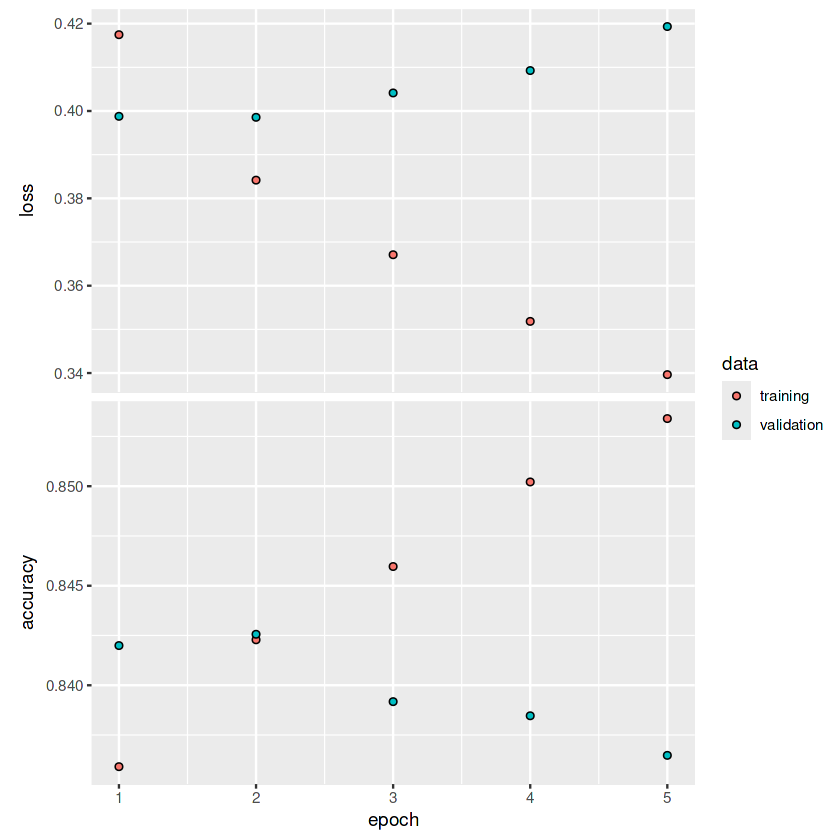

In [76]:
model_eight <- keras_model_sequential() %>%
  layer_embedding(input_dim = max_words, output_dim = 16, input_length = maxlen) %>% 
  layer_conv_1d(filters = 16, kernel_size = 3, activation = "relu") %>% 
  layer_max_pooling_1d(pool_size = 3) %>%
  layer_lstm(units = 16) %>% 
  layer_dense(units = 16, activation = "relu") %>%  
  layer_dense(units = 1, activation = "sigmoid")

model_eight %>% compile(optimizer = "adam", loss = "binary_crossentropy", metrics = c("accuracy"))

history_eight <- model_eight %>% fit(x_train, y_train, epochs = 5, batch_size = 64, validation_data = list(x_test, y_test)) 
plot(history_eight)

## GRU (Gated Recurrent Unit)

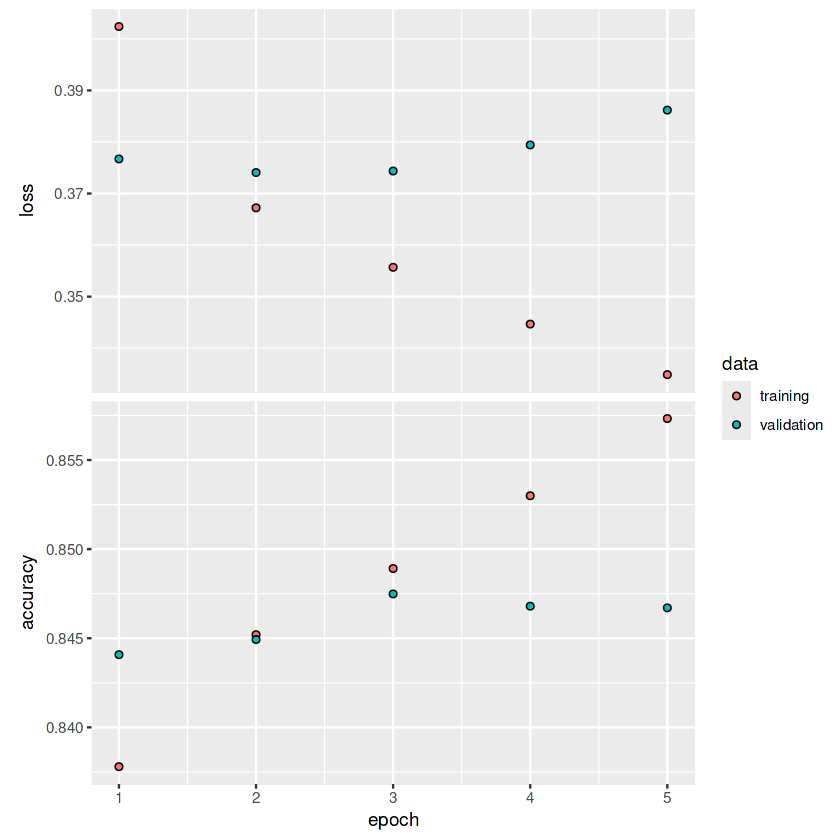

In [77]:
model_nine <- keras_model_sequential() %>%
  layer_embedding(input_dim = max_words, output_dim = 16, input_length = maxlen) %>%  
  layer_gru(units = 16) %>%
  layer_dense(units = 16, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

model_nine %>% compile(optimizer = "adam", loss = "binary_crossentropy", metrics = c("accuracy"))  

history_nine <- model_nine %>% fit(x_train, y_train, epochs = 5, batch_size = 64, validation_data = list(x_test, y_test))  
plot(history_nine)

## SSDR model

In [78]:
# Define the SSDR model
model_ssdr <- keras_model_sequential() %>%
  layer_embedding(input_dim = max_words, output_dim = 16, input_length = maxlen) %>%  
  layer_conv_1d(filters = 16, kernel_size = 3, activation = "relu") %>% 
  layer_max_pooling_1d(pool_size = 3) %>%
  layer_conv_1d(filters = 16, kernel_size = 3, activation = "relu") %>%
  layer_max_pooling_1d(pool_size = 3) %>%
  layer_flatten() %>% 
  layer_dense(units = 32, activation = "relu") %>% 
  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 2, activation = "linear") 

In [79]:
# Compile SSDR model
model_ssdr %>% compile(
  optimizer = optimizer_adam(lr = 0.001),
  loss = "mean_squared_error", 
  metrics = c("accuracy")
)

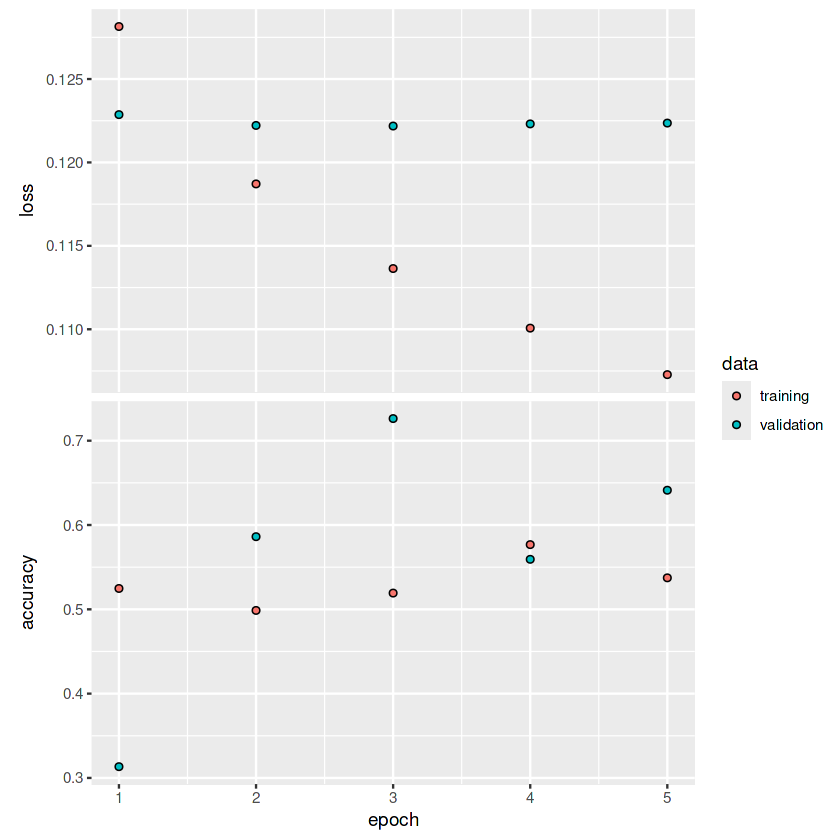

In [80]:
# Train the SSDR model 
history_ssdr <- model_ssdr %>% fit(
  x_train, y_train, 
  epochs = 5, 
  batch_size = 64, 
  validation_data = list(x_test, y_test)
)

plot(history_ssdr)

### Saving SSDR model

In [ ]:
ssdr_model %>% save_model_hdf5("ssdr_text_model.h5")
tf <- import("tensorflow")
ssdr_converter <- tf$lite$TFLiteConverter$from_keras_model(ssdr_text_model)
ssdr_tflite_model <- ssdr_converter$convert()
ssdr_tflite_model_raw <- serialize(ssdr_tflite_model, NULL)
ssdr_tflite_path <- "ssdr_text_model.tflite"
writeBin(ssdr_tflite_model_raw, ssdr_tflite_path)
cat("SSDR Model has been converted and saved as 'ssdr_text_model.tflite'.\n")

In [81]:
# Evaluate SSDR model on test set
ssdr_eval <- model_ssdr %>% evaluate(x_test, y_test)
print(ssdr_eval)

     loss  accuracy 
0.1223593 0.6412593 


In [82]:
eval_results <- tibble(
  model = c(
    "Model 1", 
    "Model 2", 
    "Model 3", 
    "Model 4", 
    "Model 5", 
    "Model 6", 
    "Model 9",
    "SSDR Model"  
  ),
  accuracy = c(
    eval_one[["accuracy"]],
    eval_two[["accuracy"]],
    eval_three[["accuracy"]],
    model_four %>% evaluate(x_test, y_test) %>% `[[`("accuracy"),
    model_five %>% evaluate(x_test, y_test) %>% `[[`("accuracy"),
    model_six %>% evaluate(x_test, y_test) %>% `[[`("accuracy"),
    model_nine %>% evaluate(x_test, y_test) %>% `[[`("accuracy"),
    ssdr_eval[["accuracy"]] 
  )
)

print(eval_results)

# A tibble: 8 × 2
  model      accuracy
  <chr>         <dbl>
1 Model 1       0.829
2 Model 2       0.824
3 Model 3       0.830
4 Model 4       0.838
5 Model 5       0.837
6 Model 6       0.847
7 Model 9       0.847
8 SSDR Model    0.641


## Saving model

In [84]:
model_list <- list(model_one, model_two, model_three, model_four, model_five, model_six, model_nine)
model_names <- c("model_one", "model_two", "model_three", "model_four", "model_five", "model_six", "model_nine")

for (i in seq_along(model_list)) {
  model <- model_list[[i]]
  model_name <- model_names[i]
  model %>% save_model_hdf5(paste0(model_name, ".h5"))
  converter <- tf$lite$TFLiteConverter$from_keras_model(model)
  converter$target_spec$supported_ops <- list(
    tf$lite$OpsSet$TFLITE_BUILTINS, 
    tf$lite$OpsSet$SELECT_TF_OPS  
  )
  converter$experimental_new_converter <- TRUE
  converter$experimental_lower_tensor_list_ops <- FALSE
  tflite_model <- converter$convert()
  tflite_model_raw <- serialize(tflite_model, NULL)
  tflite_path <- paste0(model_name, ".tflite")
  writeBin(tflite_model_raw, tflite_path)
  cat(paste(model_name, "has been converted and saved as", tflite_path, ".\n"))
}


model_one has been converted and saved as model_one.tflite .
model_two has been converted and saved as model_two.tflite .
model_three has been converted and saved as model_three.tflite .
model_four has been converted and saved as model_four.tflite .
model_five has been converted and saved as model_five.tflite .
model_six has been converted and saved as model_six.tflite .
model_nine has been converted and saved as model_nine.tflite .
